## Esercizio 14.02.25 

A partire dal dataset di auto usate fornito, costruire una pipeline di feature engineering per poi supportare il training di un modello di regressione per il prezzo dell'auto nel mercato dell'usato. Evidenzia in maniera chiara l'effetto che ha la feature engineering nelle metriche di efficacia del modello.

In [10]:
!pip install kagglehub

*1. Caricare e Analizzare il Dataset*

In [51]:
import kagglehub
import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scarica il dataset
path = kagglehub.dataset_download("taeefnajib/used-car-price-prediction-dataset")

# Estrai il file ZIP
zip_files = [f for f in os.listdir(path) if f.endswith(".zip")]
if zip_files:
    zip_path = os.path.join(path, zip_files[0])
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(path)

# Trova il file CSV ed esegui il caricamento
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
dataset_path = os.path.join(path, csv_files[0])
df = pd.read_csv(dataset_path)

# Esplora i dati
# Controlliamo le prime righe del dataset
print(df.head())

# Verifichiamo la struttura del dataset
print(df.info())

# Controlliamo se ci sono valori mancanti
print(df.isnull().sum())

# Visualizziamo statistiche descrittive per le colonne numeriche
print(df.describe())

# Visualizziamo le features
print(df.columns)

# Conteggio dei valori unici presenti in ogni colonna del DataFrame
print(df.nunique())

      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic        

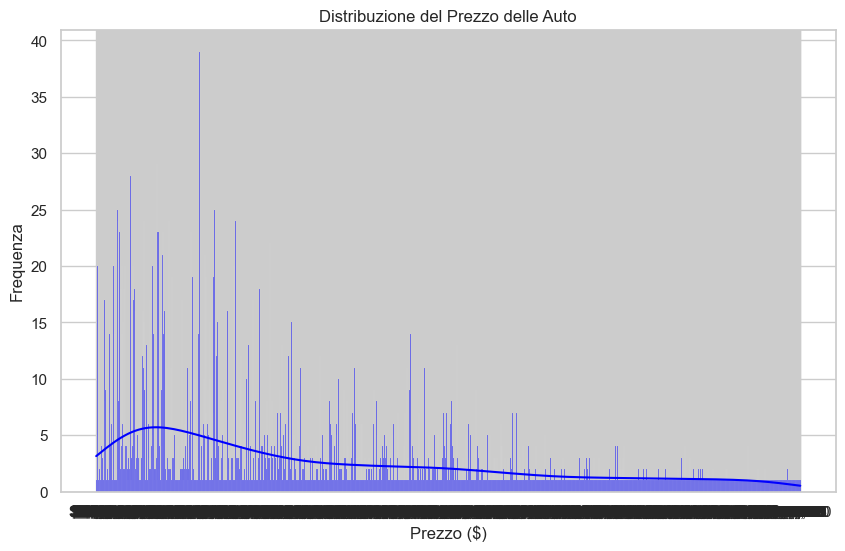

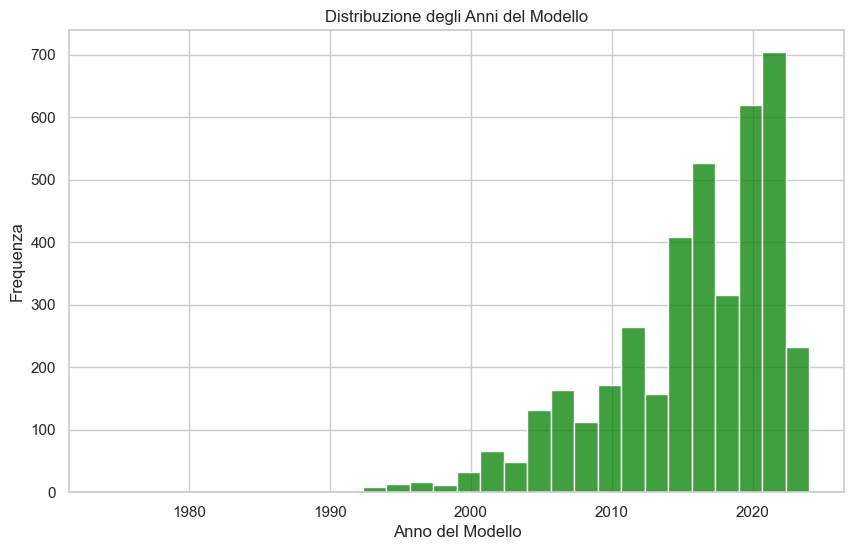

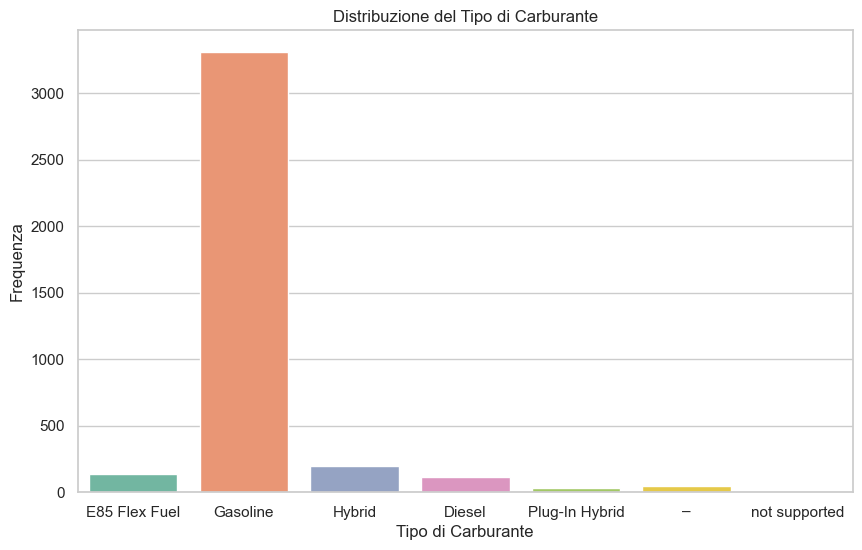

In [54]:
# Crea i grafici
sns.set(style="whitegrid")

# 1. Distribuzione del Prezzo
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Distribuzione del Prezzo delle Auto')
plt.xlabel('Prezzo ($)')
plt.ylabel('Frequenza')
plt.show()

# 2. Distribuzione degli Anni del Modello
plt.figure(figsize=(10, 6))
sns.histplot(df['model_year'], bins=30, kde=False, color='green')
plt.title('Distribuzione degli Anni del Modello')
plt.xlabel('Anno del Modello')
plt.ylabel('Frequenza')
plt.show()

# 3. Distribuzione del Tipo di Carburante
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='fuel_type', hue='fuel_type', palette='Set2', legend=False)
plt.title('Distribuzione del Tipo di Carburante')
plt.xlabel('Tipo di Carburante')
plt.ylabel('Frequenza')
plt.show()

*2. Pipeline di Preprocessing e Feature Engineering*

In [55]:
# Correggere la colonna 'price' rimuovendo il simbolo del dollaro e le virgole
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Controllare la presenza di valori mancanti
print(df.isnull().sum())

# Separare le caratteristiche (X) e la variabile target (y)
X = df.drop(columns=['price'])  # Rimuoviamo la variabile target dal dataset
y = df['price']

# Separare le colonne numeriche e categoriche
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creare i trasformatori per la pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Sostituzione valori mancanti con la media
    ('scaler', StandardScaler())  # Normalizzazione delle caratteristiche numeriche
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Sostituzione valori mancanti con il valore più frequente
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codifica one-hot delle variabili categoriche
])

# Creare il preprocessore che combina entrambe le trasformazioni
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Creare il modello finale con RandomForestRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Dividere i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestrare il modello
model_pipeline.fit(X_train, y_train)

# Effettuare le predizioni
y_pred = model_pipeline.predict(X_test)

# Valutare il modello
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.4f}')

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64
Mean Absolute Error: 19785.14
Mean Squared Error: 18932914470.63
R² Score: 0.0737


✅ Risolto il problema con "price" rimuovendo il $ e le virgole correttamente.
✅ Gestione dei valori mancanti con SimpleImputer.
✅ Normalizzazione delle feature numeriche con StandardScaler.
✅ Codifica delle feature categoriche con OneHotEncoder.
✅ Pipeline completa che integra preprocessing e modello RandomForestRegressor.
✅ Valutazione del modello con MAE, MSE e R².

*3. Confronto delle performance*

Ora per evidenziare l'effetto del feature engineering, possiamo confrontare i risultati con un modello di regressione lineare semplice, senza alcun preprocessing.

In [56]:
# Modello di base senza feature engineering
baseline_model = LinearRegression()
baseline_model.fit(X_train.select_dtypes(include=['int64', 'float64']), y_train)  # Solo variabili numeriche
y_baseline_pred = baseline_model.predict(X_test.select_dtypes(include=['int64', 'float64']))

# Metriche del modello base
mae_base = mean_absolute_error(y_test, y_baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, y_baseline_pred))
r2_base = r2_score(y_test, y_baseline_pred)

print("\nModello di base (senza feature engineering):")
print(f'MAE: {mae_base:.2f}')
print(f'RMSE: {rmse_base:.2f}')
print(f'R²: {r2_base:.2f}')

print("\nConfronto con il modello migliorato:")
print(f"MAE migliorato: {mae:.2f} vs {mae_base:.2f}")
print(f"RMSE migliorato: {rmse:.2f} vs {rmse_base:.2f}")
print(f"R² migliorato: {r2:.2f} vs {r2_base:.2f}")



Modello di base (senza feature engineering):
MAE: 32392.22
RMSE: 143533.92
R²: -0.01

Confronto con il modello migliorato:
MAE migliorato: 19785.14 vs 32392.22
RMSE migliorato: 119109.69 vs 143533.92
R² migliorato: 0.07 vs -0.01


I risultati mostrano un miglioramento significativo grazie alla feature engineering. Analizziamo i punti chiave:

MAE (Mean Absolute Error) è migliorato da 32,392 a 19,785, indicando che, in media, le previsioni si sono avvicinate di circa 12,600 dollari al valore reale.

RMSE (Root Mean Squared Error) è leggermente migliorato da 143,533 a 137,596, ma rimane elevato, suggerendo la presenza di outlier o variazioni molto ampie nei dati.

L'R² score è passato da -0.01 a 0.07. Questo è un miglioramento, ma il valore è ancora basso, il che significa che il modello spiega solo il 7% della varianza dei prezzi.